In [1]:
'''Process Digital Elevation Models (DEMs) with Python.

Author: He Zhang @ University of Exeter
Date: Mar 16th 2019
Contact: hz298@exeter.ac.uk

DEM Data:
    ASTGDEMv20  -  ASTER-GDEMv2.0
    Download Link: https://earthexplorer.usgs.gov/

Terms and Abbreviations:
    EPSG  -  European Petroleum Survey Group
    GCS   -  Geographic Coordinate System (Identified by an unique EPSG code)
    PCS   -  Projected Coordinate System (Identified by an unique EPSG code)
    WGS-84 [EPSG 4326]   -  1984 World Geodetic System [GCS]
    Merc [EPSG 3857]     -  Mercator -> Web Mercator -> Pseudo Mercator [PCS of WGS-84]
    OSGB-36 [EPSG 4277]  -  1936 Ordnance Survey Great Britain [GCS]
    BNG [EPSG 27700]     -  British National Grid [PCS of OSGB-36]
    ETRS-89 [EPSG 4258]  -  1989 European Terrestrial Reference System [GCS]
    LAEA [EPSG 3035]     -  Lambert Azimuthal Equal-Area [PCS of ETRS-89]
    lat  -  Latitude
    lng  -  Longitude
    Transform  -  GCS to GCS
    Project    -  GCS to PCS, PCS to PCS
    Convert    -  PCS to PCS

Functions:
    Remove the overlapped elements of DEMs in WGS-84 GCS.
    Merge the reformed DEMs in WGS-84 GCS.

    Transform the merged DEM from WGS-84 GCS to OSGB-36 GCS.
    Transform the merged DEM from WGS-84 GCS to ETRS-89 GCS.

    Project DEM from WGS-84 GCS to Pseudo Mercator PCS.
    Project DEM from OSGB-36 GCS to BNG PCS.
    Project DEM from ETRS-89 GCS to LAEA PCS.

    Display 2D DEM image in Pseudo Mercator PCS.
    Display 2D DEM image in BNG PCS.
    Display 2D DEM image in LAEA PCS.

    Get the elevation from DEM in WGS-84 GCS.
    Get the elevation from DEM in OSGB-36 GCS.
    Get the elevation from DEM in ETRS-89 GCS.

******************** Important Information of Code Usage ********************
- Use 'GDAL.GetProjection()' to check the GCS/PCS information of DEM (in TIF format).
- Use 'GDAL.GetGeoTransform()' to check the resolution of DEMs.
- Use 'GDAL.GetGeoTransform()' to check (lat, lng) of top-left corner of DEM (in GCS).
- The (lat, lng) of other locations in DEM can therefore be calculated.
- Each GCS has one related PCS (GCS/PCS is identified by an unique EPSG code).
- You can transform DEM between different GCSs (e.g., WGS-84 <-> OSGB-36 <-> ETRS-89).
- You can project DEM in GCS to the related PCS and then display its 2D image.
- You can not display DEM in GCS as 2D image (e.g., WGS-84 -> 2D image is wrong).
- You can not project DEM in GCS to the unrelated PCS (e.g., WGS-84 -> BNG is wrong).
- You can not project DEM between different PCSs (e.g., Pseudo Mercator <-> BNG is wrong).
* Use 'gdalwarp' command to transform/project DEM to different GCSs/PCSs might be correct.
'''

import os
import re
# import shutil
# import subprocess

# import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from pandas import read_csv

from pyDEM_function import get_dem_info
from pyDEM_function import get_elevation
from pyDEM_function import get_file_names
from pyDEM_function import show_2d_dem
from pyDEM_function import transprojcnvt_dem
from pyDEM_function import write_dem



In [2]:
# Specify user settings.

# Set the format of DEMs.
DEM_FORMAT = '.tif'

# Set the path of DEMs.
PATH_ASTGDEM = "DATA/DATA_ASTGDEMv20/"
PATH_ASTGDEM_SOURCE = "DATA/DATA_ASTGDEMv20/EPSG4326_s/"  # The folder of source DEMs must exist.
PATH_ASTGDEM_REFORM = "DATA/DATA_ASTGDEMv20/EPSG4326_r/"  # The folder of reformed DEMs.

# Set the name of DEMs in GCSs.
ASTGDEM_GCS_WD = "ASTGDEMv20_EPSG4326.tif"
ASTGDEM_GCS_UK = "ASTGDEMv20_EPSG4277.tif"
ASTGDEM_GCS_EU = "ASTGDEMv20_EPSG4258.tif"

# Set the name of DEMs in PCSs.
ASTGDEM_PCS_WD = "ASTGDEMv20_EPSG3857.tif"
ASTGDEM_PCS_UK = "ASTGDEMv20_EPSG27700.tif"
ASTGDEM_PCS_EU = "ASTGDEMv20_EPSG3035.tif"

# Set the path for saving 2D DEM images.
IMG_PATH_ASTGDEM = "IMG_ASTGDEMv20/"

# Set the name of 2D DEM images.
IMG_NAME_ASTGDEM_WD = "LD_ASTGDEMv20_EPSG3857"
IMG_NAME_ASTGDEM_UK = "LD_ASTGDEMv20_EPSG27700"
IMG_NAME_ASTGDEM_EU = "LD_ASTGDEMv20_EPSG3035"

# Set the path of location data file.
PATH_LD_STATION_DATA = "DATA/DATA_LD_AirQuality/London_AirQuality_Stations.csv"


In [3]:
# <ASTGDEMv20> Remove the overlapped elements of DEMs in WGS-84 GCS.

print('\n>>> <ASTGDEMv20> Remove the overlapped elements of DEMs in WGS-84 GCS.')

file_names = get_file_names(PATH_ASTGDEM_SOURCE, DEM_FORMAT)
file_names.sort(reverse=True)  # W -> E

for i, file_name in enumerate(file_names):
    print('\n>>> Process the %d-th DEM: %s' % (i + 1, file_name))

    gdal_data = gdal.Open(PATH_ASTGDEM_SOURCE + file_name)
    i_row, i_col, i_band, i_gt, i_proj = get_dem_info(gdal_data, 1)
    print('\n*==> The shape of DEM is: [%d, %d]' % (i_row, i_col))

    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan

    # Remove the overlapped elements of DEM.
    dem_reform = gdal_array
    dem_reform = np.delete(dem_reform, -1, axis=0)  # Delete the last/bottom row of DEM.
    dem_reform = np.delete(dem_reform, -1, axis=1)  # Delete the last/right column of DEM.
    print('\n*==> The shape of the reformed DEM is: [%d, %d]' % (dem_reform.shape[0], dem_reform.shape[1]))

    print('\n>>> Write the reformed DEM to:', file_name)
    path = PATH_ASTGDEM_REFORM
    if os.path.exists(path) is False:
        os.mkdir(path)
    if os.path.isfile(path + file_name) is True:
        os.remove(path + file_name)
    write_dem(path + file_name, dem_reform, dem_reform.shape[0], dem_reform.shape[1], i_band, i_gt, i_proj)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Remove the overlapped elements of DEMs in WGS-84 GCS.

>>> Process the 1-th DEM: ASTGTM2_N51W001_dem.tif

The information of DEM:
The number of row (height) is: 3601
The number of column (width) is: 3601
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

*==> The shape of DEM is: [3601, 3601]

*==> The shape of the reformed DEM is: [3600, 3600]

>>> Write the reformed DEM to: ASTGTM2_N51W001_dem.tif

>>> Process the 2-th DEM: ASTGTM2_N51E000_dem.tif

The information of DEM:
The number of row (height) is: 3601
The number of column (width) is: 3601
The number of band is: 1
The 6 GeoTransform parameters are:
 (-0.0001388888888888889,

In [4]:
# <ASTGDEMv20> Merge the reformed DEMs in WGS-84 GCS.

print('\n>>> <ASTGDEMv20> Merge the reformed DEMs in WGS-84 GCS.')

dem_merge = []
dem_out = ASTGDEM_GCS_WD

file_names = get_file_names(PATH_ASTGDEM_REFORM, DEM_FORMAT)
file_names.sort(reverse=True)  # W -> E

for i, file_name in enumerate(file_names):
    if 'ASTGTM2' in file_name:
        print('\n>>> Read the %d-th DEM: %s' % (i + 1, file_name))

        gdal_data = gdal.Open(PATH_ASTGDEM_REFORM + file_name)
        i_row, i_col, i_band, i_gt, i_proj = get_dem_info(gdal_data, 1)
        print('\n*==> The shape of DEM is: [%d, %d]' % (i_row, i_col))

        gdal_array = gdal_data.ReadAsArray().astype(np.float)
        gdal_band = gdal_data.GetRasterBand(1)
        nodataval = gdal_band.GetNoDataValue()
        if np.any(gdal_array == nodataval):
            gdal_array[gdal_array == nodataval] = np.nan

        # Merge the reformed DEMs. - Not perfect.
        name_lat = re.findall(r'-?\d+\.?\d*', file_name)[1]
        name_log = re.findall(r'-?\d+\.?\d*', file_name)[2]

        if name_lat == '51':
            if name_log == '001':
                dem_merge = gdal_array
            else:
                dem_merge = np.concatenate((dem_merge, gdal_array), axis=1)

print('\n*==> The shape of the merged DEM is: [%d, %d]' % (dem_merge.shape[0], dem_merge.shape[1]))

# Get the GeoTransform parameters of the merged DEM from the left-top DEM ('file_names[0]').
gdal_data = gdal.Open(PATH_ASTGDEM_REFORM + file_names[0])
lt_row, lt_col, lt_band, lt_gt, lt_proj = get_dem_info(gdal_data)

print('\n>>> Write the merged DEM to:', dem_out)
path = PATH_ASTGDEM
if os.path.exists(path) is False:
    os.mkdir(path)
if os.path.isfile(path + dem_out) is True:
        os.remove(path + dem_out)
write_dem(path + dem_out, dem_merge, dem_merge.shape[0], dem_merge.shape[1], lt_band, lt_gt, lt_proj)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Merge the reformed DEMs in WGS-84 GCS.

>>> Read the 1-th DEM: ASTGTM2_N51W001_dem.tif

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 3600
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

*==> The shape of DEM is: [3600, 3600]

>>> Read the 2-th DEM: ASTGTM2_N51E000_dem.tif

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 3600
The number of band is: 1
The 6 GeoTransform parameters are:
 (-0.0001388888888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["W

In [5]:
# <ASTGDEMv20> Transform the merged DEM from WGS-84 GCS to OSGB-36 GCS.

print('\n>>> <ASTGDEMv20> Transform the merged DEM from WGS-84 GCS to OSGB-36 GCS.')

path = PATH_ASTGDEM
dem_in = path + ASTGDEM_GCS_WD
dem_out = path + ASTGDEM_GCS_UK

epsg_in = 4326
epsg_out = 4277

transprojcnvt_dem(dem_in, epsg_in, dem_out, epsg_out)

data = gdal.Open(dem_in)
get_dem_info(data, 1)
data = gdal.Open(dem_out)
get_dem_info(data, 1)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Transform the merged DEM from WGS-84 GCS to OSGB-36 GCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
The GCS/PCS information is:
 GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.

In [6]:
# <ASTGDEMv20> Transform the merged DEM from WGS-84 GCS to ETRS-89 GCS.

print('\n>>> <ASTGDEMv20> Transform the merged DEM from WGS-84 GCS to ETRS-89 GCS.')

path = PATH_ASTGDEM
dem_in = path + ASTGDEM_GCS_WD
dem_out = path + ASTGDEM_GCS_EU

epsg_in = 4326
epsg_out = 4258

transprojcnvt_dem(dem_in, epsg_in, dem_out, epsg_out)

data = gdal.Open(dem_in)
get_dem_info(data, 1)
data = gdal.Open(dem_out)
get_dem_info(data, 1)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Transform the merged DEM from WGS-84 GCS to ETRS-89 GCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777774, 0.0, 52.000138888888884, 0.0, -0.0002777777777777774)
The GCS/PCS information is:
 GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],TOWGS8

In [7]:
# <ASTGDEMv20> Project DEM from WGS-84 GCS to Pseudo Mercator PCS.

print('\n>>> <ASTGDEMv20> Project DEM from WGS-84 GCS to Pseudo Mercator PCS.')

path = PATH_ASTGDEM
dem_in = path + ASTGDEM_GCS_WD
dem_out = path + ASTGDEM_PCS_WD

epsg_in = 4326
epsg_out = 3857

transprojcnvt_dem(dem_in, epsg_in, dem_out, epsg_out)

data = gdal.Open(dem_in)
get_dem_info(data, 1)
data = gdal.Open(dem_out)
get_dem_info(data, 1)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Project DEM from WGS-84 GCS to Pseudo Mercator PCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

The information of DEM:
The number of row (height) is: 5041
The number of column (width) is: 6276
The number of band is: 1
The 6 GeoTransform parameters are:
 (-111334.95183366156, 35.474973641899794, 0.0, 6800150.567328675, 0.0, -35.474973641899794)
The GCS/PCS information is:
 PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"

In [8]:
# <ASTGDEMv20> Project DEM from OSGB-36 GCS to BNG PCS.

print('\n>>> <ASTGDEMv20> Project DEM from OSGB-36 GCS to BNG PCS.')

path = PATH_ASTGDEM
dem_in = path + ASTGDEM_GCS_UK
dem_out = path + ASTGDEM_PCS_UK

epsg_in = 4277
epsg_out = 27700

transprojcnvt_dem(dem_in, epsg_in, dem_out, epsg_out)

data = gdal.Open(dem_in)
get_dem_info(data, 1)
data = gdal.Open(dem_out)
get_dem_info(data, 1)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Project DEM from OSGB-36 GCS to BNG PCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
The GCS/PCS information is:
 GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]]

The information of DEM:
The number of row (height) is: 5203
The number of column (width) is: 6418
The number of band is: 1
The 6 GeoTransform parameters are:
 (468736.14475350257, 22.101898961294147, 0.0, 237774.34151860897, 0.0, -22.101898961294147)
The GCS/PCS information is:
 PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["A

In [9]:
# <ASTGDEMv20> Project DEM from ETRS-89 GCS to LAEA PCS.

print('\n>>> <ASTGDEMv20> Project DEM from ETRS-89 GCS to LAEA PCS.')

path = PATH_ASTGDEM
dem_in = path + ASTGDEM_GCS_EU
dem_out = path + ASTGDEM_PCS_EU

epsg_in = 4258
epsg_out = 3035

transprojcnvt_dem(dem_in, epsg_in, dem_out, epsg_out)

data = gdal.Open(dem_in)
get_dem_info(data, 1)
data = gdal.Open(dem_out)
get_dem_info(data, 1)

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Project DEM from ETRS-89 GCS to LAEA PCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777774, 0.0, 52.000138888888884, 0.0, -0.0002777777777777774)
The GCS/PCS information is:
 GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]]

The information of DEM:
The number of row (height) is: 5852
The number of column (width) is: 6901
The number of band is: 1
The 6 GeoTransform parameters are:
 (3552161.2997090546, 22.104339263837893, 0.0, 3266941.5106412214, 0.0, -22.104339263837893)
The GCS/PCS information is:
 PROJCS["ETRS89 / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHER


>>> <ASTGDEMv20> Display 2D DEM image in Pseudo Mercator PCS.

The shape of DEM is: [5041, 6276]


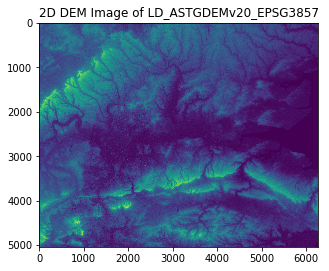


>>> <ASTGDEMv20> Display 2D DEM image in BNG PCS.

The shape of DEM is: [5203, 6418]


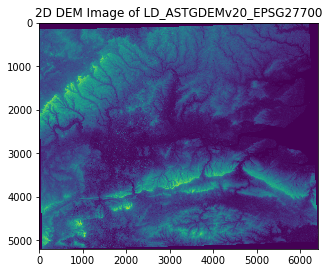


>>> <ASTGDEMv20> Display 2D DEM image in LAEA PCS.

The shape of DEM is: [5852, 6901]


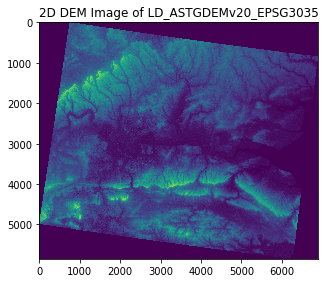


>>> Complete!



In [10]:
# <ASTGDEMv20> Display DEM in PCS as a 2D image.

dem_path = PATH_ASTGDEM
img_path = IMG_PATH_ASTGDEM

# Create the path for saving 2D DEM images.
if os.path.exists(img_path) is False:
    os.mkdir(img_path)

# Display 2D DEM image in Pseudo Mercator PCS.
print('\n>>> <ASTGDEMv20> Display 2D DEM image in Pseudo Mercator PCS.')
dem_name = ASTGDEM_PCS_WD
img_name = IMG_NAME_ASTGDEM_WD
show_2d_dem(dem_path, dem_name, img_path, img_name)

# Display 2D DEM image in BNG PCS.
print('\n>>> <ASTGDEMv20> Display 2D DEM image in BNG PCS.')
dem_name = ASTGDEM_PCS_UK
img_name = IMG_NAME_ASTGDEM_UK
show_2d_dem(dem_path, dem_name, img_path, img_name)

# Display 2D DEM image in LAEA PCS.
print('\n>>> <ASTGDEMv20> Display 2D DEM image in LAEA PCS.')
dem_name = ASTGDEM_PCS_EU
img_name = IMG_NAME_ASTGDEM_EU
show_2d_dem(dem_path, dem_name, img_path, img_name)

print('\n>>> Complete!\n')


In [11]:
# Read London air quality monitoring station data file.

print('\n>>> Read London air quality monitoring station data file.')

site_data = read_csv(PATH_LD_STATION_DATA)
print(site_data.head(3))

site_num = site_data['SiteName'].count()
print('\n*==> The number of stations is: %d' % site_num)

# Get the latitude and longitude of stations.
site_latlng = np.zeros((site_num, 2))
site_latlng[:, 0] = site_data['Latitude']  # 0-th column - Latitude.
site_latlng[:, 1] = site_data['Longitude']  # 1-th column - Longitude.

np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print('\n*==> The location (lat, lng) of stations are:\n', site_latlng)

print('\n>>> Complete!\n')



>>> Read London air quality monitoring station data file.
  Unnamed: 0 api_data need_prediction  historical_data   Latitude  Longitude  \
0        BX9     True             NaN             True  51.465983   0.184877   
1        BX1     True             NaN             True  51.465983   0.184877   
2        BL0     True            True             True  51.522287  -0.125848   

           SiteType                   SiteName  
0          Suburban  Bexley - Slade Green FDMS  
1          Suburban       Bexley - Slade Green  
2  Urban Background        Camden - Bloomsbury  

*==> The number of stations is: 24

*==> The location (lat, lng) of stations are:
 [[51.46598327  0.18487713]
 [51.46598327  0.18487713]
 [51.522287   -0.125848  ]
 [51.52770662 -0.12905321]
 [51.544219   -0.175284  ]
 [51.51452534 -0.10451563]
 [51.51384718 -0.07776568]
 [51.410039   -0.127523  ]
 [51.490532    0.074003  ]
 [51.45258     0.070766  ]
 [51.486957    0.095111  ]
 [51.456357    0.040725  ]
 [51.4563      0

In [12]:
# <ASTGDEMv20> Get the elevation from DEM in WGS-84 GCS.

print('\n>>> <ASTGDEMv20> Get the elevation from DEM in WGS-84 GCS.')

dem_gcs = gdal.Open(PATH_ASTGDEM + ASTGDEM_GCS_WD)
get_dem_info(dem_gcs, 1)

site_ele_astgdem_wgs = get_elevation(dem_gcs, site_latlng)
np.set_printoptions(suppress=True)

print('\n*==> The elevation information of stations is:\n', site_ele_astgdem_wgs)
print('\n*==> The elevation value of stations is:\n', site_ele_astgdem_wgs[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Get the elevation from DEM in WGS-84 GCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
The GCS/PCS information is:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]

The 6 GeoTransform parameters of DEM are:
 (-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)

*==> The elevation information of stations is:
 [[   0.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   1.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   2.           51.522287     -0.125848   1720.         3147.
    38.        ]
 [   3.       

In [13]:
# <ASTGDEMv20> Get the elevation from DEM in OSGB-36 GCS.

print('\n>>> <ASTGDEMv20> Get the elevation from DEM in OSGB-36 GCS.')

dem_gcs = gdal.Open(PATH_ASTGDEM + ASTGDEM_GCS_UK)
get_dem_info(dem_gcs, 1)

site_ele_astgdem_osgb = get_elevation(dem_gcs, site_latlng)
np.set_printoptions(suppress=True)

print('\n*==> The elevation information of stations is:\n', site_ele_astgdem_osgb)
print('\n*==> The elevation value of stations is:\n', site_ele_astgdem_osgb[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Get the elevation from DEM in OSGB-36 GCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
The GCS/PCS information is:
 GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]]

The 6 GeoTransform parameters of DEM are:
 (-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)

*==> The elevation information of stations is:
 [[   0.           51.46598327    0.18487713 1921.         4260.
    14.        ]
 [   1.           51.46598327    0.18487713 1921.         4260.
    14.        ]
 [   2.        

In [14]:
# <ASTGDEMv20> Get the elevation from DEM in ETRS-89 GCS.

print('\n>>> <ASTGDEMv20> Get the elevation from DEM in ETRS-89 GCS.')

dem_gcs = gdal.Open(PATH_ASTGDEM + ASTGDEM_GCS_EU)
get_dem_info(dem_gcs, 1)

site_ele_astgdem_etrs = get_elevation(dem_gcs, site_latlng)
np.set_printoptions(suppress=True)

print('\n*==> The elevation information of stations is:\n', site_ele_astgdem_etrs)
print('\n*==> The elevation value of stations is:\n', site_ele_astgdem_etrs[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> <ASTGDEMv20> Get the elevation from DEM in ETRS-89 GCS.

The information of DEM:
The number of row (height) is: 3600
The number of column (width) is: 7200
The number of band is: 1
The 6 GeoTransform parameters are:
 (-1.000138888888889, 0.0002777777777777774, 0.0, 52.000138888888884, 0.0, -0.0002777777777777774)
The GCS/PCS information is:
 GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]]

The 6 GeoTransform parameters of DEM are:
 (-1.000138888888889, 0.0002777777777777774, 0.0, 52.000138888888884, 0.0, -0.0002777777777777774)

*==> The elevation information of stations is:
 [[   0.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   1.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   2.           51.522287  

In [15]:
# Compare the elevation obtained from different DEMs.

print('\n>>> Compare the elevation obtained from different DEMs.')

print('\nASTGDEMv20_WD', site_ele_astgdem_wgs[:, 5].astype(int))
print('\nASTGDEMv20_UK', site_ele_astgdem_osgb[:, 5].astype(int))
print('\nASTGDEMv20_EU', site_ele_astgdem_etrs[:, 5].astype(int))

print('\n>>> Complete!\n')



>>> Compare the elevation obtained from different DEMs.

ASTGDEMv20_WD [18 18 38 40 65 26 35 31 17 79 13 41 62 82  9 13 31 31 15 22 24 40  8 40]

ASTGDEMv20_UK [14 14 36 25 60 37 33 40 20 68 12 25 62 59 15 18 22 22 15 21 14 33  8 47]

ASTGDEMv20_EU [18 18 38 40 65 26 35 31 17 79 13 41 62 82  9 13 31 31 15 22 24 40  8 40]

>>> Complete!

